**Sentiment Analysis on Public Domain Novels**

I will be doing sentiment analysis on ten books publically available from Project Gutenberg: https://www.gutenberg.org/

First, I import the relevant libraries needed to scrape and analyze the text. Then, for each book I want, I use the requests library to pull the full text from the link. Only the number in the link changes between books; the format stays the same otherwise. (Links were found via Google because Project Gutenberg has specific rules about bots accessing their page and will ban you if you break them!).

I used the sentence tokenizer from the nltk (natural language toolkit) library to split the text into sentences. It has varying levels of success. Then, I used the sentiment classifier from above to get the sentiment of each sentence. It's important to note that there are many non-sentence sentences, such as chapter titles, or the text introducing the book.

I included code to write each book to a csv file and to read them back in, so that the sentiment classifier doesn't need to be run each time you want to look at the data (it is slow). In a Jupyter Notebook, you can just use pd.read_csv('path\to\file.csv'), but because I was writing this in Google Colab, I had to do things a little bit differently.

Because of encoding issues that occurred when pulling the text from gutenberg.org, I went into each csv and used find and replace to fix the special characters. I think this could have been done in the code using a different encoder (e.g 'latin-1' vs 'utf-8').

After collecting all the data, I analyzed it to compare the sentiments of the ten novels.

In [1]:
#install transformers
!pip install  transformers 

#install umap
!pip install umap-learn

In [2]:
!git clone https://github.com/zlisto/sentiment_analysis
import os
os.chdir("sentiment_analysis")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import codecs
import umap
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import math


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"device ={device}")
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

Cloning into 'sentiment_analysis'...


device =cuda


In [3]:
def sentiment_classifier(text,model,tokenizer):
    inputs = tokenizer.encode_plus(text, return_tensors='pt', add_special_tokens=True)

    token_type_ids = inputs['token_type_ids']
    input_ids = inputs['input_ids']

    output = model(input_ids, token_type_ids=token_type_ids,return_dict=True,output_hidden_states=True)
    logits = np.array(output.logits.tolist()[0])
    prob = np.exp(logits)/np.sum(np.exp(logits))
    sentiment = np.sum([(x+1)*prob[x] for x in range(len(prob))])  #use this line if you want the mean score
    embedding = output.hidden_states[12].detach().numpy().squeeze()[0]
    
    return sentiment, embedding

In [4]:
from http import HTTPStatus
import requests
import nltk
nltk.download('punkt')
from nltk.tokenize import *
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#gather the information for each book and write to csv files
booknames=['Scarlet_df','TwoCities_df','Gatsby_df','Dorian_df','Frankenstein_df','Eyre_df','Cristo_df','Walden_df','TimeMachine_df','GreatEx_df']
booknumbers=['25344','98','64317','174','42324','1260','1184','205','35','1400']
d = {}
for name,number in zip(booknames,booknumbers):
  print('Working on ',name)
  d[name] = pd.DataFrame(columns=['Text','Sentiment'])
  url='https://www.gutenberg.org/cache/epub/' + number+'/pg'+number+'.txt'
  response = requests.get(url)
  assert response.status_code == HTTPStatus.OK
  source = response.text
  #break text into sentences
  tokenized_text=sent_tokenize(source)
  i=0
  for sentence in tokenized_text:
    d[name].loc[i,'Text']=sentence
    if len(sentence)>512:
      d[name].loc[i,'Sentiment']=sentiment_classifier(sentence[0:511],model,tokenizer)[0]
    else:
      d[name].loc[i,'Sentiment']=sentiment_classifier(sentence,model,tokenizer)[0]
    i=i+1
  d[name].to_csv(name+'.csv')

Working on  Scarlet_df
Working on  TwoCities_df
Working on  Gatsby_df
Working on  Dorian_df
Working on  Frankenstein_df
Working on  Eyre_df
Working on  Cristo_df
Working on  Walden_df
Working on  TimeMachine_df
Working on  GreatEx_df


In [6]:
#only run this part if you already created the csvs and stored them elsewhere (need to change path to where your files are)
df_Frankenstein = pd.read_csv('/content/drive/MyDrive/Data/Frankenstein.csv')
df_Gatsby=pd.read_csv('/content/drive/MyDrive/Data/Gatsby.csv',encoding='latin-1')
df_TwoCities=pd.read_csv('/content/drive/MyDrive/Data/TwoCities.csv')
df_Scarlet=pd.read_csv('/content/drive/MyDrive/Data/Scarlet.csv',encoding='latin-1')
df_Dorian=pd.read_csv('/content/drive/MyDrive/Data/Dorian.csv',encoding='latin-1')

Eyre_df = pd.read_csv('/content/drive/MyDrive/Data/Eyre_df.csv')
GreatEx_df=pd.read_csv('/content/drive/MyDrive/Data/GreatEx_df.csv',encoding='latin-1')
Walden_df=pd.read_csv('/content/drive/MyDrive/Data/Walden_df.csv')
TimeMachine_df=pd.read_csv('/content/drive/MyDrive/Data/TimeMachine_df.csv',encoding='latin-1')
Cristo_df=pd.read_csv('/content/drive/MyDrive/Data/Cristo_df.csv',encoding='latin-1')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Data/Frankenstein.csv'

In [6]:
#combine all the sentiments into one df (fills in length differences with na)
combined_dfs = pd.DataFrame({'A Tale of Two Cities': df_TwoCities['Sentiment'],
                             'The Great Gatsby': df_Gatsby['Sentiment'],
                             'The Scarlet Letter': df_Scarlet['Sentiment'],
                             'The Picture of Dorian Gray': df_Dorian['Sentiment'],
                             'Frankenstein': df_Frankenstein['Sentiment'],
                             'Jane Eyre':Eyre_df['Sentiment'],
                             'The Count of Monte Cristo':Cristo_df['Sentiment'],
                             'Walden':Walden_df['Sentiment'],
                             'The Time Machine':TimeMachine_df['Sentiment'],
                             'Great Expectations':GreatEx_df['Sentiment']})

(array([ 35., 186., 435., 709., 761., 646., 469., 425., 337., 168.]),
 array([1.1225014 , 1.50082784, 1.87915428, 2.25748073, 2.63580717,
        3.01413361, 3.39246005, 3.77078649, 4.14911294, 4.52743938,
        4.90576582]),
 <a list of 10 Patch objects>)

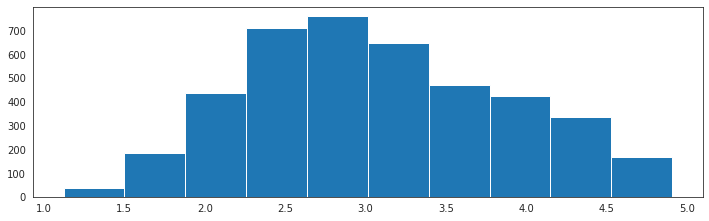

In [49]:
plt.hist(Walden_df['Sentiment']) #look at the distribution of sentiment for the books; most take on about the same shape

In [36]:
#get the medians so that the box plots below can be ordered by median
med=pd.DataFrame(columns=['df','med'])
i=0
for col in combined_dfs.columns.to_list():
  med.loc[i,'df']=col
  med.loc[i,'med']=combined_dfs[col].median()
  print(col,combined_dfs[col].median())
  i=i+1
newcolorder=med.sort_values('med')['df'].to_list()

A Tale of Two Cities 2.7617838514999997
The Great Gatsby 2.7663591715
The Scarlet Letter 2.961320363
The Picture of Dorian Gray 2.796345243
Frankenstein 2.984138690225352
Jane Eyre 2.752150330676578
The Count of Monte Cristo 2.8286314135210664
Walden 2.985704675572265
The Time Machine 2.62633308735383
Great Expectations 2.7388823566587988


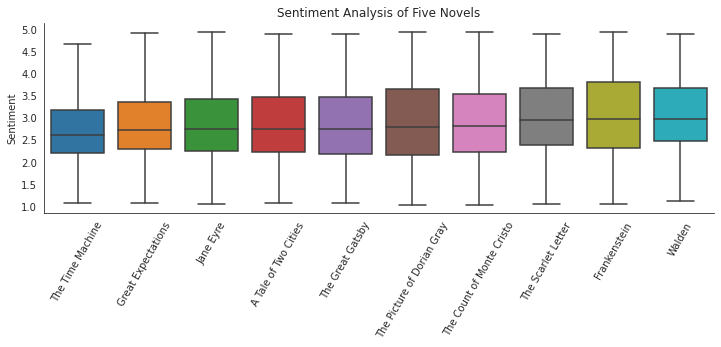

<Figure size 576x576 with 0 Axes>

In [37]:
#median_vals=[df['Sentiment'].median() for df in [df_TwoCities,df_Gatsby,df_Scarlet,df_Dorian,df_Frankenstein,Eyre_df,Cristo_df,Walden_df,TimeMachine_df,GreatEx_df]]
sns.set_style('white')
sns.boxplot(data=combined_dfs[newcolorder],showfliers=False)
sns.despine()
plt.rcParams["figure.figsize"] = [12, 3.50]
plt.xticks(rotation=60)
plt.ylabel('Sentiment')
plt.title('Sentiment Analysis of Five Novels')
plt.figure(figsize=(8, 8))
plt.show()

In [40]:
#set up a df to hold assorted info about each book
attributes=pd.DataFrame(columns=['Average','Median','Variance'],index=['A Tale of Two Cities','The Great Gatsby','The Scarlet Letter','The Picture of Dorian Gray','Frankenstein','Jane Eyre','The Time Machine','Great Expectations','Walden','The Count of Monte Cristo'])
for novel in combined_dfs.columns.to_list():
  attributes.loc[novel,'Average']=combined_dfs[novel].mean()
  attributes.loc[novel,'Median']=combined_dfs[novel].median()
  attributes.loc[novel,'Variance']=combined_dfs[novel].var()
attributes['Year']=[1859,1925,1850,1890,1818,1847,1895,1860,1854,1844] #via wikipedia
attributes['Pages']=[448,208,272,288,220,592,66,512,172,640]#via barnesandnoble.com

In [43]:
#split each book into tenths and get average sentiment for each tenth
df_Normalized=pd.DataFrame(columns=['A Tale of Two Cities','The Great Gatsby','The Scarlet Letter','The Picture of Dorian Gray','Frankenstein','Jane Eyre','The Time Machine','Great Expectations','Walden','The Count of Monte Cristo'],index=range(1,11))
for novel,df in zip(combined_dfs.columns.to_list(),[df_TwoCities,df_Gatsby,df_Scarlet,df_Dorian,df_Frankenstein,Eyre_df,Cristo_df,Walden_df,TimeMachine_df,GreatEx_df]):
  x=0
  for i in range(1,11):
    df_Normalized.loc[i,novel]=combined_dfs[novel][x:x+math.floor(len(df['Sentiment'])/10)].mean()
    x=x+math.floor(len(df['Sentiment'])/10)
    i=i+1


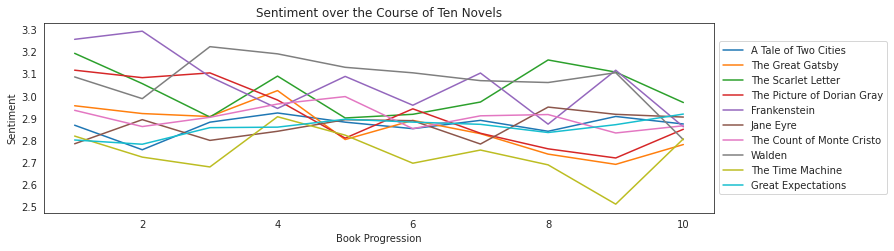

In [44]:
#plot the sentiment across each book, can comment out lines to isolate certain books
#looks like great expectations and a tale of two cities follow a similar path
plt.plot(df_Normalized.index,df_Normalized['A Tale of Two Cities'], label = "A Tale of Two Cities")
plt.plot(df_Normalized.index,df_Normalized['The Great Gatsby'], label = "The Great Gatsby")
plt.plot(df_Normalized.index,df_Normalized['The Scarlet Letter'], label = "The Scarlet Letter")
plt.plot(df_Normalized.index,df_Normalized['The Picture of Dorian Gray'], label = "The Picture of Dorian Gray")
plt.plot(df_Normalized.index,df_Normalized['Frankenstein'], label = "Frankenstein")
plt.plot(df_Normalized.index,df_Normalized['Jane Eyre'], label = "Jane Eyre")
plt.plot(df_Normalized.index,df_Normalized['The Count of Monte Cristo'], label = "The Count of Monte Cristo")
plt.plot(df_Normalized.index,df_Normalized['Walden'], label = "Walden")
plt.plot(df_Normalized.index,df_Normalized['The Time Machine'], label = "The Time Machine")
plt.plot(df_Normalized.index,df_Normalized['Great Expectations'], label = "Great Expectations")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Book Progression")
plt.ylabel("Sentiment")
plt.title('Sentiment over the Course of Ten Novels')
plt.show()

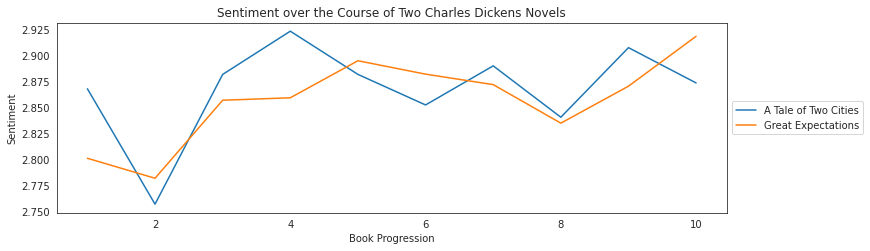

In [46]:
#just look at charles dickens novels; they have a pretty similar trajectory
plt.plot(df_Normalized.index,df_Normalized['A Tale of Two Cities'], label = "A Tale of Two Cities")
plt.plot(df_Normalized.index,df_Normalized['Great Expectations'], label = "Great Expectations")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Book Progression")
plt.ylabel("Sentiment")
plt.title('Sentiment over the Course of Two Charles Dickens Novels')
plt.show()

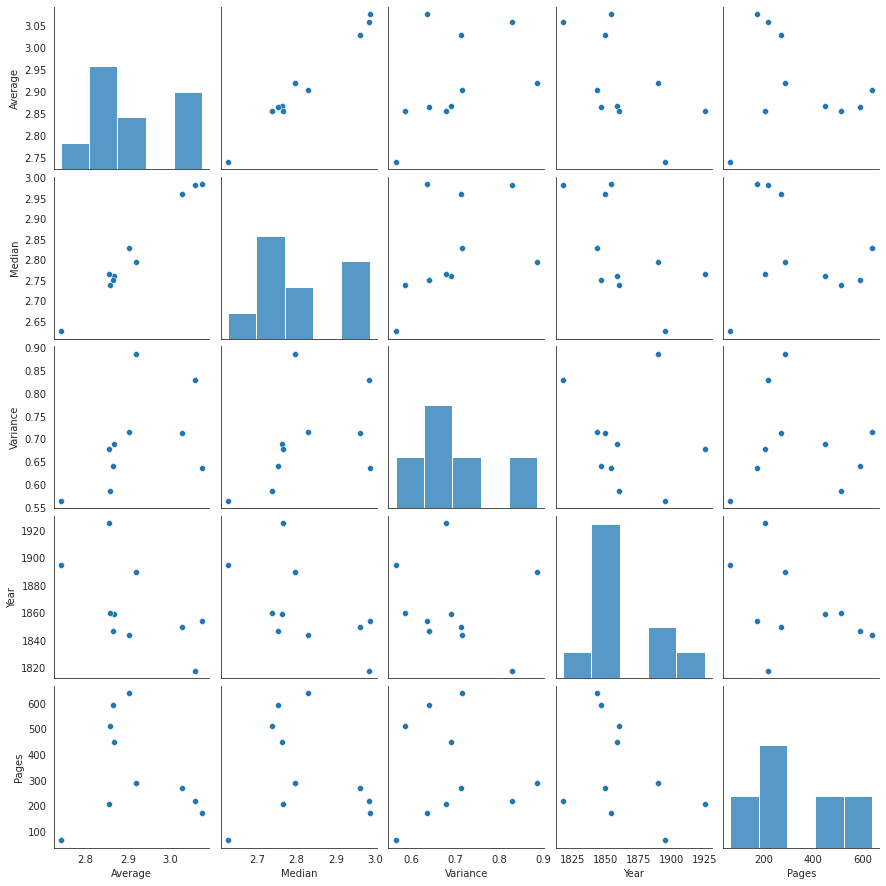

In [45]:
#there isn't much that data, but from what we have, it doesn't look like there is a strong relationship between any two attributes (except mean and median, but that's to be expected)
sns.pairplot(attributes)

Possible Next Steps/Areas to Explore:


*   Making a quantitative measure of how similar the trajectories of each book are
*   Get more books by the same author to see if the sentiment trends over the duration of each book are similar


*   Further research how the model is trained and if it could be more accurate if trained specifically on older text
*   Fix the encoding issue that is messing up special characters




